In [20]:
from typing import Dict

import tensorflow as tf
from tensorflow.keras import layers

from matplotlib import pyplot as plt 

In [42]:
BATCH_SIZE = 256
LATENT_DIM = 100 

BUFFER_SIZE = 60_000 # size of dataset 

In [73]:
class VanillaGAN(tf.keras.Model):
    def __init__(self, discriminator: tf.keras.Model, generator: tf.keras.Model, latent_dim: int, batch_size: int = BATCH_SIZE):
        super(VanillaGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.batch_size = BATCH_SIZE
        
        
    def save_model(self, path: str):
        self.save_weights(path)
    
    @classmethod
    def load_model(cls, path: str, **kwargs) -> "VanillaGAN":
        discriminator = tf.keras.models.load_model(kwargs['discriminator_path'])
        generator = tf.keras.models.load_model(kwargs['generator_path'])
        latent_dim = kwargs['latent_dim']
        gan = cls(discriminator, generator, latent_dim, **kwargs)
        gan.load_weights(path)
        return gan

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(VanillaGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, data: tf.Tensor) -> Dict[str, tf.Tensor]:
        X = tf.cast(data, tf.float32)  # Ensure data type consistency
        batch_size = tf.shape(X)[0]
        
        #######################
        #   Prepare Inputs    #
        #######################
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        
        # Generate fake images
        x_generator = self.generator(random_latent_vectors)
        
        # Combine real and fake images
        combined_images = tf.concat([x_generator, X], axis=0)
        
        # Create labels for discriminator
        real_labels = tf.ones((self.batch_size, 1))
        fake_labels = tf.zeros((self.batch_size, 1))
        labels = tf.concat([real_labels, fake_labels], axis=0)
        
        # Add random noise to labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        labels = tf.clip_by_value(labels, 0, 1)  # Keep labels in range [0, 1]
        
        #######################
        # Train Discriminator #
        #######################
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            # Ensure shape compatibility
            predictions = tf.reshape(predictions, tf.shape(labels))
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        #######################
        #   Train Generator   #
        #######################
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        
        # Misleading labels for generator training
        misleading_labels = tf.ones((self.batch_size, 1))  # Pretend generated images are real
        
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        #######################
        #   Return Losses     #
        #######################
        return {"d_loss": d_loss, "g_loss": g_loss}



In [74]:

def generate_latent_points(batch_size, NOISE_DIM): 
    return tf.random.normal([batch_size, NOISE_DIM])


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [75]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

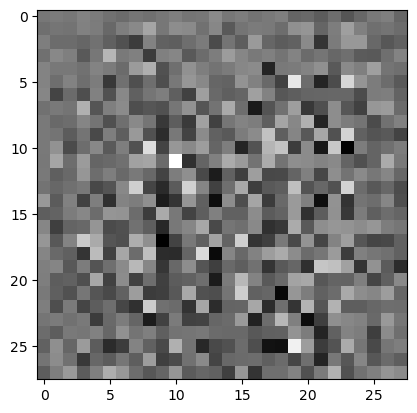

In [76]:
generator = make_generator_model()

noise = generate_latent_points(1, 100)
img = generator(noise, training=False)

plt.imshow(img[0, :, :, 0], cmap="gray")

In [77]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [78]:
discriminator = make_discriminator_model()
decision = discriminator(img)
print(decision)

tf.Tensor([[0.00163669]], shape=(1, 1), dtype=float32)


In [79]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [80]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [81]:
import os 

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [82]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [83]:
gan = VanillaGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

In [85]:
# Load MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize and cast the images to float32 and scale to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = tf.expand_dims(train_images, axis=-1)  # Add a channel dimension (for grayscale)

# Create a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [86]:
gan.fit(
    train_dataset, 
    epochs = EPOCHS, 
    verbose=1,   
)

Epoch 1/50
233/235 [============================>.] - ETA: 0s - d_loss: 0.1982 - g_loss: 0.0892

InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/mul_1' defined at (most recent call last):
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\asyncio\windows_events.py", line 316, in run_forever
      super().run_forever()
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\NiXoN\AppData\Local\Temp\ipykernel_23112\2730592735.py", line 1, in <module>
      gan.fit(
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\NiXoN\AppData\Local\Temp\ipykernel_23112\1491548344.py", line 61, in train_step
      d_loss = self.loss_fn(labels, predictions)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\NiXoN\miniconda3\envs\local_thesis_conda\lib\site-packages\keras\backend.py", line 5686, in binary_crossentropy
      bce += (1 - target) * tf.math.log(1 - output + epsilon())
Node: 'binary_crossentropy/mul_1'
required broadcastable shapes
	 [[{{node binary_crossentropy/mul_1}}]] [Op:__inference_train_function_8718]